**Task**

Your task is to answer a series of questions about trends in crimes in Chicago for a reporter for the local newspaper.

- Stakeholder Questions to Answer (pick at least 3 topics) Select 3 or more of the following topics to analyze:
    - 1) Comparing Police Districts:
        - Which district has the most crimes? Which has the least?
    - 2) Crimes Across the Years:
        - Is the total number of crimes increasing or decreasing across the years?
        - Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?
    - 3) Comparing AM vs. PM Rush Hour:
        - Are crimes more common during AM rush hour or PM rush hour?
            - You can consider any crime that occurred between 7 AM - 10 AM as AM rush hour
            - You can consider any crime that occurred between 4 -7 PM as PM rush hour.
        - What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
        - Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?
- 4) Comparing Months:
    - What months have the most crime? What months have the least?
    - Are there any individual crimes that do not follow this pattern? If so, which crimes?
- 5) Comparing Holidays:
    - Are there any holidays that show an increase in the # of crimes?
    - Are there any holidays that show a decrease in the # of crimes?

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns

import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

import glob
import pandas as pd
folder = "Data/Chicago/"
crime_files = sorted(glob.glob(folder+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])

In [3]:
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1310586,01/01/2001 01:00:00 AM,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856
1,1311144,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110
2,1310288,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608
3,6808288,01/01/2001 01:00:00 PM,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632
4,1325760,01/01/2001 01:00:00 PM,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
101087,13092455,05/31/2023 12:50:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822
101088,13091442,05/31/2023 12:50:00 PM,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570
101089,13093687,05/31/2023 12:52:00 PM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489
101090,13094726,05/31/2023 12:55:00 PM,CRIMINAL TRESPASS,TO LAND,RESTAURANT,False,False,112,1.0,34.0,41.882425,-87.624378


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813154 entries, 0 to 101091
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 670.6+ MB


## Preparing the Datetime Index
### Converting Date Cols to Datetime

In [3]:
try:
    df['Date'] = pd.to_datetime(df["Date"])
    display(df.head())
except Exception as e:
    display(e)

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1310586,2001-01-01 01:00:00,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856
1,1311144,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110
2,1310288,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608
3,6808288,2001-01-01 13:00:00,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632
4,1325760,2001-01-01 13:00:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN


In [4]:
##check nulls before coercing errors
df.isna().sum()

ID                           0
Date                         0
Primary Type                 0
Description                  0
Location Description     10563
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614848
Latitude                 87496
Longitude                87496
dtype: int64

In [5]:
## saving a copy of original datetime column
df['datetime-original'] = df['Date'].copy()
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,datetime-original
0,1310586,2001-01-01 01:00:00,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856,2001-01-01 01:00:00
1,1311144,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110,2001-01-01 01:00:00
2,1310288,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608,2001-01-01 01:00:00
3,6808288,2001-01-01 13:00:00,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632,2001-01-01 13:00:00
4,1325760,2001-01-01 13:00:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN,2001-01-01 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101087,13092455,2023-05-31 12:50:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822,2023-05-31 12:50:00
101088,13091442,2023-05-31 12:50:00,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570,2023-05-31 12:50:00
101089,13093687,2023-05-31 12:52:00,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489,2023-05-31 12:52:00
101090,13094726,2023-05-31 12:55:00,CRIMINAL TRESPASS,TO LAND,RESTAURANT,False,False,112,1.0,34.0,41.882425,-87.624378,2023-05-31 12:55:00


In [7]:
## Using errors = "coerce"
df["datetime-coerce"] = pd.to_datetime(df["Date"], errors='coerce')
df["datetime-coerce"]

0        2001-01-01 01:00:00
1        2001-01-01 01:00:00
2        2001-01-01 01:00:00
3        2001-01-01 13:00:00
4        2001-01-01 13:00:00
                 ...        
101087   2023-05-31 12:50:00
101088   2023-05-31 12:50:00
101089   2023-05-31 12:52:00
101090   2023-05-31 12:55:00
101091   2023-05-31 12:57:00
Name: datetime-coerce, Length: 7813154, dtype: datetime64[ns]

In [10]:
## How many null values did we create?
df.isna().sum()

ID                           0
Date                         0
Primary Type                 0
Description                  0
Location Description     10563
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614848
Latitude                 87496
Longitude                87496
datetime-original            0
datetime-coerce              0
dtype: int64

In [18]:
df_ts = df.set_index('Date')
df_ts

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,datetime-original,datetime-coerce
Date,,,,,,,,,,,,,
2001-01-01 01:00:00,1310586,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856,2001-01-01 01:00:00,2001-01-01 01:00:00
2001-01-01 01:00:00,1311144,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110,2001-01-01 01:00:00,2001-01-01 01:00:00
2001-01-01 01:00:00,1310288,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608,2001-01-01 01:00:00,2001-01-01 01:00:00
2001-01-01 13:00:00,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632,2001-01-01 13:00:00,2001-01-01 13:00:00
2001-01-01 13:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN,2001-01-01 13:00:00,2001-01-01 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 12:50:00,13092455,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822,2023-05-31 12:50:00,2023-05-31 12:50:00
2023-05-31 12:50:00,13091442,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570,2023-05-31 12:50:00,2023-05-31 12:50:00
2023-05-31 12:52:00,13093687,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489,2023-05-31 12:52:00,2023-05-31 12:52:00


In [19]:
dt_cols = [c for c in df_ts.columns if 'datetime' in c]
df_ts = df_ts.drop(columns=dt_cols)
df_ts

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1310586,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856
2001-01-01 01:00:00,1311144,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110
2001-01-01 01:00:00,1310288,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608
2001-01-01 13:00:00,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632
2001-01-01 13:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 12:50:00,13092455,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822
2023-05-31 12:50:00,13091442,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570
2023-05-31 12:52:00,13093687,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489


In [20]:
# check the index to confirm its datetime
df_ts.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 13:00:00',
               '2001-01-01 13:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 13:00:00', '2001-01-01 13:00:00',
               ...
               '2023-05-31 12:38:00', '2023-05-31 00:38:00',
               '2023-05-31 12:45:00', '2023-05-31 00:45:00',
               '2023-05-31 00:47:00', '2023-05-31 12:50:00',
               '2023-05-31 12:50:00', '2023-05-31 12:52:00',
               '2023-05-31 12:55:00', '2023-05-31 12:57:00'],
              dtype='datetime64[ns]', name='Date', length=7813154, freq=None)

## Getting Our Time Series of UFO Sightings

In [22]:
## A.1) Add a count column with a value of 1 for each row and then use reasmple().sum()
demo_ts = df_ts.copy() 
demo_ts['Count'] = 1
demo_ts

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Count
Date,,,,,,,,,,,,
2001-01-01 01:00:00,1310586,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856,1
2001-01-01 01:00:00,1311144,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110,1
2001-01-01 01:00:00,1310288,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608,1
2001-01-01 13:00:00,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632,1
2001-01-01 13:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 12:50:00,13092455,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822,1
2023-05-31 12:50:00,13091442,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570,1
2023-05-31 12:52:00,13093687,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489,1


In [23]:
# A.2) 
demo_ts.resample('D').sum()#['Count']

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/2363162109.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  demo_ts.resample('D').sum()#['Count']


,ID,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Count
Date,,,,,,,,,
2001-01-01,4011740634,399,289,2267987,21147.0,8194.0,72641.077994,-152199.715024,1825
2001-01-02,1545846568,383,146,1404493,12797.0,147.0,47664.670569,-99856.853277,1143
2001-01-03,1542074517,343,162,1462886,13359.0,132.0,48045.805839,-100651.350927,1151
2001-01-04,1555657957,377,131,1397040,12994.0,0.0,48785.523718,-102222.916683,1166
2001-01-05,1701884634,415,159,1530155,14044.0,156.0,52769.463977,-110554.590960,1267
...,...,...,...,...,...,...,...,...,...
2023-05-27,9384501493,82,140,813001,7966.0,16267.0,30042.439547,-62945.268569,727
2023-05-28,9960747219,82,151,877419,8597.0,16955.0,31760.754370,-66539.564776,763
2023-05-29,9136732124,91,129,797091,7812.0,16612.0,28793.026600,-60316.736400,698


### Make `ts` from ufo_ts

In [25]:
ts = df_ts.resample('D').size()
ts

Date
2001-01-01    1825
2001-01-02    1143
2001-01-03    1151
2001-01-04    1166
2001-01-05    1267
              ... 
2023-05-27     727
2023-05-28     763
2023-05-29     698
2023-05-30     664
2023-05-31     633
Freq: D, Length: 8186, dtype: int64

In [26]:
plt.rcParams['figure.figsize'] = [10,5]

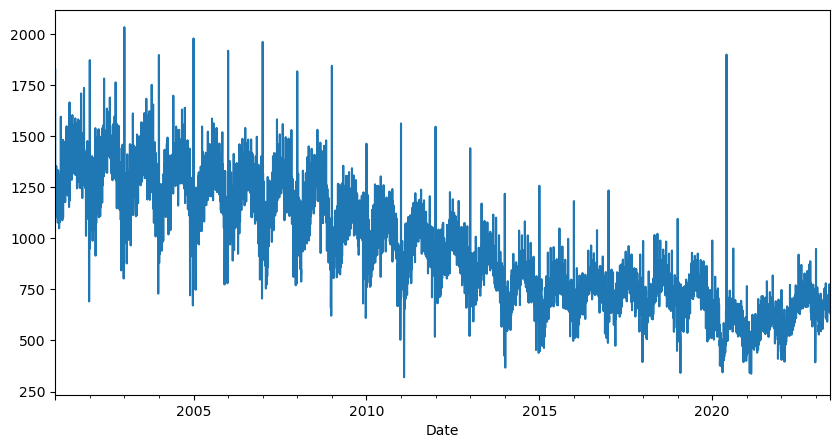

In [27]:
ts.plot();

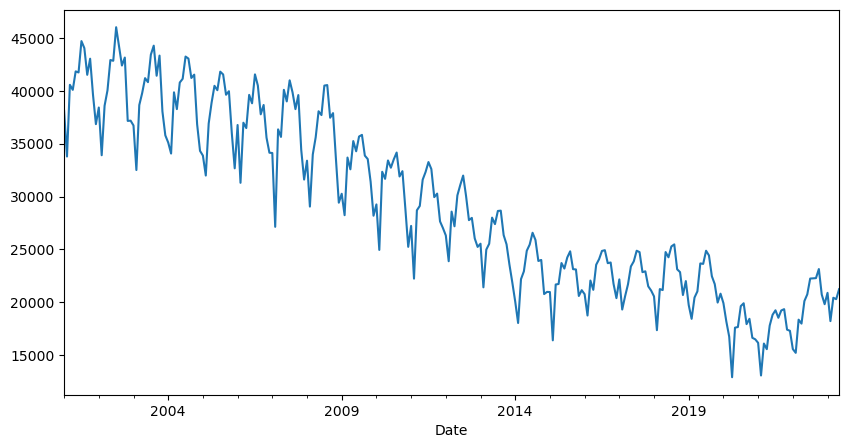

In [28]:
## save our new frequency ts and plot
ts_m = ts.resample("M").sum()
ts_m.plot();

### Making `eda_df` for answering questions

In [29]:
## making eda_df with date as a column instead of index
eda_df = df_ts.reset_index()
eda_df

,Date,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,2001-01-01 01:00:00,1310586,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856
1,2001-01-01 01:00:00,1311144,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110
2,2001-01-01 01:00:00,1310288,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608
3,2001-01-01 13:00:00,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632
4,2001-01-01 13:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7813149,2023-05-31 12:50:00,13092455,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822
7813150,2023-05-31 12:50:00,13091442,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570
7813151,2023-05-31 12:52:00,13093687,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489
7813152,2023-05-31 12:55:00,13094726,CRIMINAL TRESPASS,TO LAND,RESTAURANT,False,False,112,1.0,34.0,41.882425,-87.624378


### Feature Engineering: Date Parts

In [31]:
## feature engineering for dates
eda_df['year'] = eda_df['Date'].dt.year
eda_df['month'] = eda_df['Date'].dt.month_name()
eda_df['day of month'] = eda_df['Date'].dt.day
eda_df['day of week'] = eda_df['Date'].dt.day_name()
eda_df['hour'] = eda_df['Date'].dt.hour
eda_df

,Date,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,year,month,day of month,day of week,hour
0,2001-01-01 01:00:00,1310586,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856,2001,January,1,Monday,1
1,2001-01-01 01:00:00,1311144,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110,2001,January,1,Monday,1
2,2001-01-01 01:00:00,1310288,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608,2001,January,1,Monday,1
3,2001-01-01 13:00:00,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632,2001,January,1,Monday,13
4,2001-01-01 13:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN,2001,January,1,Monday,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813149,2023-05-31 12:50:00,13092455,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822,2023,May,31,Wednesday,12
7813150,2023-05-31 12:50:00,13091442,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570,2023,May,31,Wednesday,12
7813151,2023-05-31 12:52:00,13093687,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489,2023,May,31,Wednesday,12
7813152,2023-05-31 12:55:00,13094726,CRIMINAL TRESPASS,TO LAND,RESTAURANT,False,False,112,1.0,34.0,41.882425,-87.624378,2023,May,31,Wednesday,12


### Making `eda_ts` & `ts`

In [32]:
## Making eda_ts with dt index
eda_ts = eda_df.set_index('Date')

# Questions -
# 1) Comparing Police Districts:
## Which district has the most crimes? Which has the least?

In [36]:
eda_ts['Count'] = 1

In [37]:
eda_ts['District'].value_counts()

8.0     524976
11.0    501293
6.0     456923
7.0     451626
25.0    444506
4.0     443561
3.0     396237
12.0    387322
9.0     381670
2.0     369931
19.0    350788
18.0    350673
5.0     346207
10.0    336605
15.0    334732
1.0     316093
14.0    302261
16.0    261586
22.0    256086
24.0    236058
17.0    225526
20.0    138201
31.0       242
21.0         4
Name: District, dtype: int64

- Distric 8 had the most crimes and distric 21 had the least

# 2) Crimes Across the Years:
## Is the total number of crimes increasing or decreasing across the years?
## Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?

In [39]:
## First, resample the data as annual 
df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
df_year

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = eda_ts.groupby('Description').resample('A').sum()['Count'].reset_index()
/var/folders/5f/y13jb9491kgdgn16m3t57fq80000gn/T/ipykernel_1671/4068450135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

,Description,Date,Count
0,$300 AND UNDER,2001-12-31,5
1,$300 AND UNDER,2002-12-31,2
2,$300 AND UNDER,2003-12-31,0
3,$300 AND UNDER,2004-12-31,0
4,$300 AND UNDER,2005-12-31,1
...,...,...,...
8367,WIREROOM/SPORTS,2007-12-31,5
8368,WIREROOM/SPORTS,2008-12-31,0
8369,WIREROOM/SPORTS,2009-12-31,0
8370,WIREROOM/SPORTS,2010-12-31,1


In [40]:
## can pivot the result to have the datetime as the index and the crime as the columns
years_ts = df_year.pivot(index='Date',columns='Description')
years_ts.head()

Count                                                 \
Description $300 AND UNDER $500 AND UNDER ABUSE / NEGLECT - CARE FACILITY   
Date                                                                        
2001-12-31             5.0        61784.0                             NaN   
2002-12-31             2.0        47494.0                             NaN   
2003-12-31             0.0        37024.0                             NaN   
2004-12-31             0.0        35872.0                             NaN   
2005-12-31             1.0        27920.0                             NaN   

                                                  \
Description ABUSE/NEGLECT: CARE FACILITY ADULTRY   
Date                                               
2001-12-31                           NaN     NaN   
2002-12-31                           2.0     2.0   
2003-12-31                          11.0     1.0   
2004-12-31                          12.0     1.0   
2005-12-31                           3.0     0.0   

                                                                     \
Description AGG CRIM SEX ABUSE FAM MEMBER AGG CRIMINAL SEXUAL ABUSE   
Date                                                                  
2001-12-31                          152.0                     472.0   
2002-12-31                          154.0                     453.0   
2003-12-31                          190.0                     487.0   
2004-12-31                          191.0                     425.0   
2005-12-31                          192.0                     427.0   

                                                                     \
Description AGG PO HANDS ETC SERIOUS INJ AGG PO HANDS NO/MIN INJURY   
Date                                                                  
2001-12-31                           NaN                      386.0   
2002-12-31                           NaN                      586.0   
2003-12-31                          20.0                      960.0   
2004-12-31                          44.0                     1048.0   
2005-12-31                          33.0                     1202.0   

                                           ...  \
Description AGG PRO EMP HANDS SERIOUS INJ  ...   
Date                                       ...   
2001-12-31                            NaN  ...   
2002-12-31                            NaN  ...   
2003-12-31                           18.0  ...   
2004-12-31                           21.0  ...   
2005-12-31                           17.0  ...   

                                                    \
Description VIOLATION OF STALKING NO CONTACT ORDER   
Date                                                 
2001-12-31                                     NaN   
2002-12-31                                     NaN   
2003-12-31                                     NaN   
2004-12-31                                     NaN   
2005-12-31                                     NaN   

                                          \
Description VIOLATION OF SUMMARY CLOSURE   
Date                                       
2001-12-31                           NaN   
2002-12-31                           NaN   
2003-12-31                           NaN   
2004-12-31                           NaN   
2005-12-31                           NaN   

                                                    \
Description VIOLENT OFFENDER - ANNUAL REGISTRATION   
Date                                                 
2001-12-31                                     NaN   
2002-12-31                                     NaN   
2003-12-31                                     NaN   
2004-12-31                                     NaN   
2005-12-31                                     NaN   

                                                 \
Description VIOLENT OFFENDER - DUTY TO REGISTER   
Date                                              
2001-12-31                                  NaN   
2002-12-31               

In [41]:
years_ts.columns

MultiIndex([('Count',                                  '$300 AND UNDER'),
            ('Count',                                  '$500 AND UNDER'),
            ('Count',                 'ABUSE / NEGLECT - CARE FACILITY'),
            ('Count',                    'ABUSE/NEGLECT: CARE FACILITY'),
            ('Count',                                         'ADULTRY'),
            ('Count',                   'AGG CRIM SEX ABUSE FAM MEMBER'),
            ('Count',                       'AGG CRIMINAL SEXUAL ABUSE'),
            ('Count',                    'AGG PO HANDS ETC SERIOUS INJ'),
            ('Count',                      'AGG PO HANDS NO/MIN INJURY'),
            ('Count',                   'AGG PRO EMP HANDS SERIOUS INJ'),
            ...
            ('Count',          'VIOLATION OF STALKING NO CONTACT ORDER'),
            ('Count',                    'VIOLATION OF SUMMARY CLOSURE'),
            ('Count',          'VIOLENT OFFENDER - ANNUAL REGISTRATION'),
            ('Count', 

In [42]:
years_ts.columns = years_ts.columns.droplevel(0)
years_ts.columns

Index(['$300 AND UNDER', '$500 AND UNDER', 'ABUSE / NEGLECT - CARE FACILITY',
       'ABUSE/NEGLECT: CARE FACILITY', 'ADULTRY',
       'AGG CRIM SEX ABUSE FAM MEMBER', 'AGG CRIMINAL SEXUAL ABUSE',
       'AGG PO HANDS ETC SERIOUS INJ', 'AGG PO HANDS NO/MIN INJURY',
       'AGG PRO EMP HANDS SERIOUS INJ',
       ...
       'VIOLATION OF STALKING NO CONTACT ORDER',
       'VIOLATION OF SUMMARY CLOSURE',
       'VIOLENT OFFENDER - ANNUAL REGISTRATION',
       'VIOLENT OFFENDER - DUTY TO REGISTER',
       'VIOLENT OFFENDER - FAIL TO REGISTER NEW ADDRESS',
       'VIOLENT OFFENDER: ANNUAL REGISTRATION',
       'VIOLENT OFFENDER: DUTY TO REGISTER',
       'VIOLENT OFFENDER: FAIL TO REGISTER NEW ADDRESS', 'WIREROOM/HORSES',
       'WIREROOM/SPORTS'],
      dtype='object', name='Description', length=546)

In [48]:
### Substract to get delta crmes
delta_crime_yrs = years_ts.loc['2021-12-31'] - years_ts.loc['2023-12-31']
delta_crime_yrs


Description
$300 AND UNDER                                       NaN
$500 AND UNDER                                    9268.0
ABUSE / NEGLECT - CARE FACILITY                      5.0
ABUSE/NEGLECT: CARE FACILITY                         NaN
ADULTRY                                              NaN
                                                   ...  
VIOLENT OFFENDER: ANNUAL REGISTRATION                NaN
VIOLENT OFFENDER: DUTY TO REGISTER                   NaN
VIOLENT OFFENDER: FAIL TO REGISTER NEW ADDRESS       NaN
WIREROOM/HORSES                                      NaN
WIREROOM/SPORTS                                      NaN
Length: 546, dtype: float64

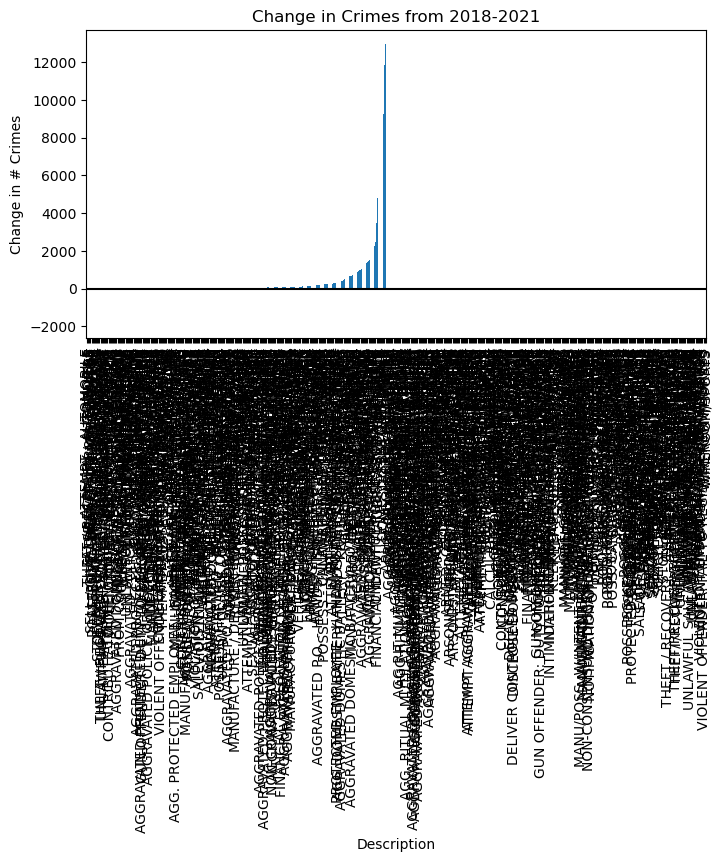

In [49]:
ax = delta_crime_yrs.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2018-2021')
ax.axhline(0,color='k');

# 3) Comparing AM vs. PM Rush Hour:

## Are crimes more common during AM rush hour or PM rush hour?
- You can consider any crime that occurred between 7 AM - 10 AM as AM rush hour
- You can consider any crime that occurred between 4 -7 PM as PM rush hour.

## What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
- Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?

# 4) Comparing Months:
## What months have the most crime? What months have the least?
## Are there any individual crimes that do not follow this pattern? If so, which crimes?

In [45]:
eda_ts['month'].value_counts()

July         717155
August       710350
May          704094
June         681678
October      676182
September    668164
March        650053
April        647397
January      621992
November     608880
December     579659
February     547550
Name: month, dtype: int64

- July had the most crimes and February the least

# 5) Comparing Holidays:
## Are there any holidays that show an increase in the # of crimes?
## Are there any holidays that show a decrease in the # of crimes?

In [50]:
!pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.3/541.3 kB 5.6 MB/s eta 0:00:00a 0:00:01


In [51]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [52]:
## create a test holiday 
test = "01/01/2015"
test

'01/01/2015'

In [53]:
## test the api 
us_holidays.get(test)

"New Year's Day"

In [54]:
## Saving both holiday types as columns
eda_df["US Holiday"] = eda_df['Date'].map(us_holidays.get)
eda_df

,Date,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,year,month,day of month,day of week,hour,US Holiday
0,2001-01-01 01:00:00,1310586,THEFT,$500 AND UNDER,STREET,False,False,911,9.0,NaN,41.798298,-87.692856,2001,January,1,Monday,1,New Year's Day
1,2001-01-01 01:00:00,1311144,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110,2001,January,1,Monday,1,New Year's Day
2,2001-01-01 01:00:00,1310288,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,621,6.0,NaN,41.756650,-87.641608,2001,January,1,Monday,1,New Year's Day
3,2001-01-01 13:00:00,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632,2001,January,1,Monday,13,New Year's Day
4,2001-01-01 13:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN,2001,January,1,Monday,13,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813149,2023-05-31 12:50:00,13092455,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1632,16.0,38.0,41.952182,-87.793822,2023,May,31,Wednesday,12,None
7813150,2023-05-31 12:50:00,13091442,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,725,7.0,15.0,41.775086,-87.666570,2023,May,31,Wednesday,12,None
7813151,2023-05-31 12:52:00,13093687,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,CURRENCY EXCHANGE,False,False,124,1.0,28.0,41.867230,-87.641489,2023,May,31,Wednesday,12,None
7813152,2023-05-31 12:55:00,13094726,CRIMINAL TRESPASS,TO LAND,RESTAURANT,False,False,112,1.0,34.0,41.882425,-87.624378,2023,May,31,Wednesday,12,None


In [55]:
eda_df['US Holiday'].value_counts()

New Year's Day                                     33580
Independence Day                                   22669
Labor Day                                          22162
Memorial Day                                       21821
Columbus Day                                       20918
Veterans Day                                       20416
Martin Luther King Jr. Day                         18590
Washington's Birthday                              18224
Thanksgiving                                       14794
Christmas Day                                      12415
Independence Day (Observed)                         5884
Veterans Day (Observed)                             5842
New Year's Day (Observed)                           5524
Christmas Day (Observed)                            4927
Juneteenth National Independence Day                1450
Juneteenth National Independence Day (Observed)     1402
Name: US Holiday, dtype: int64